## Egyptian hieroglyph classification

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import skimage
from skimage import io
from skimage.transform import resize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

Article
 - https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9528382&tag=1

Dataset
 - https://drive.google.com/drive/folders/1bhnMJ8NbCa-qw53EKy-olZp3cJKZU_jc
 - https://drive.google.com/drive/folders/1X5HdFvgWJOVtA-GxBLr1K_0FHJS2RZcZ

In [2]:
train_dir = os.path.join(sys.path[0], 'train/')
test_dir = os.path.join(sys.path[0], 'test/')

In [3]:
def readHieroglyphData(data_dir):
    images = []
    targets = []
    for hier in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, hier)):
            continue
        for img in os.listdir(os.path.join(data_dir, hier)):
            targets.append(hier)
            images.append(np.asarray(io.imread(os.path.join(data_dir, hier, img))))
    return images, targets

In [4]:
def resizeImageData(data, image_size):
    resize_func = lambda img: resize(img, (image_size, image_size), anti_aliasing=True)
    resized_data = list(map(resize_func, data))
    return resized_data

In [5]:
images_train, targets_train = readHieroglyphData(train_dir)

In [6]:
images_test, targets_test = readHieroglyphData(test_dir)

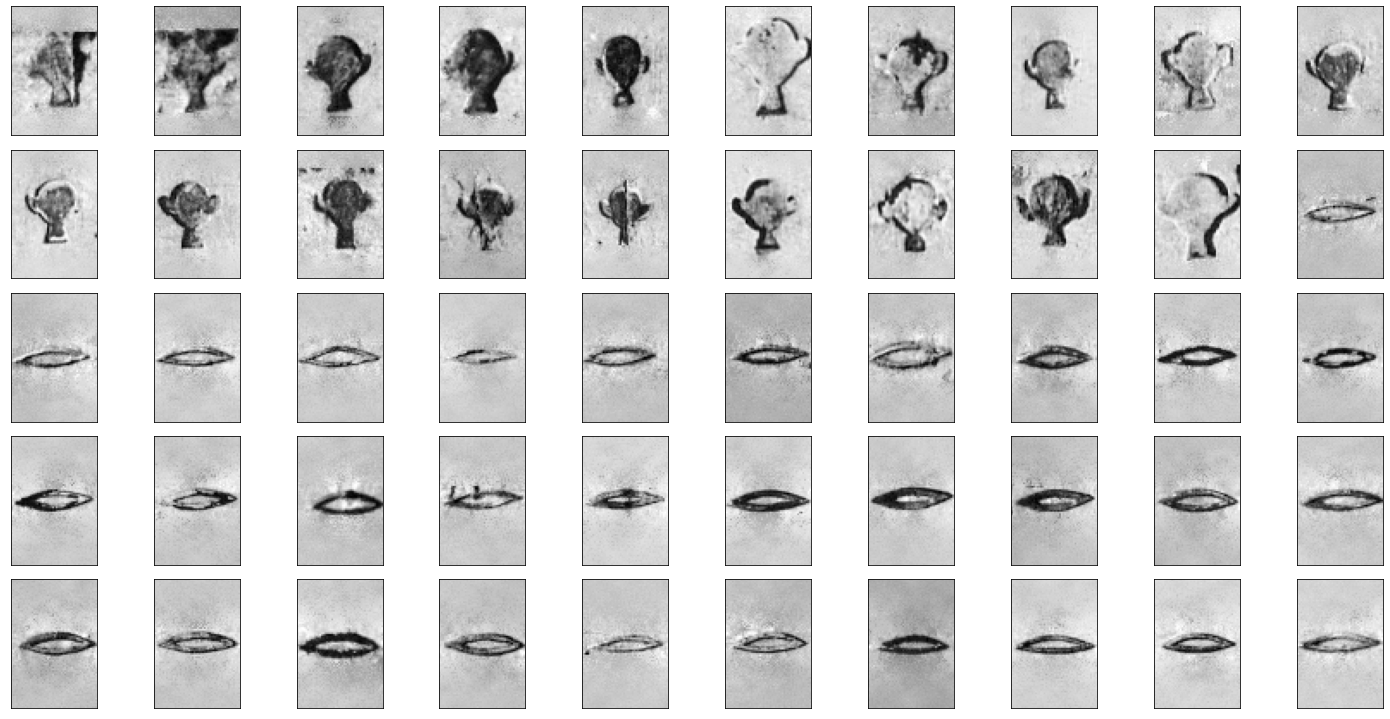

In [7]:
def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(X[i], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

overview(0, 50, images_train)

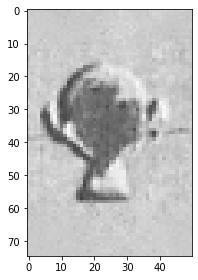

D2


In [8]:
io.imshow(images_test[0], cmap='gray')
io.show()
print(targets_test[0])

In [9]:
len(targets_train)

2467

In [10]:
len(targets_test)

635

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(targets_train)
LabelEncoder()
print(list(le.classes_))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']


In [12]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_labels = len(le.classes_)

# expand depth channel
x_train = np.expand_dims(images_train, -1) 
x_test = np.expand_dims(images_test, -1)

#resize images with padding
x_train = tf.image.resize_with_pad(
    x_train,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

x_test = tf.image.resize_with_pad(
    x_test,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

TensorShape([2467, 100, 100, 1])

Resized images

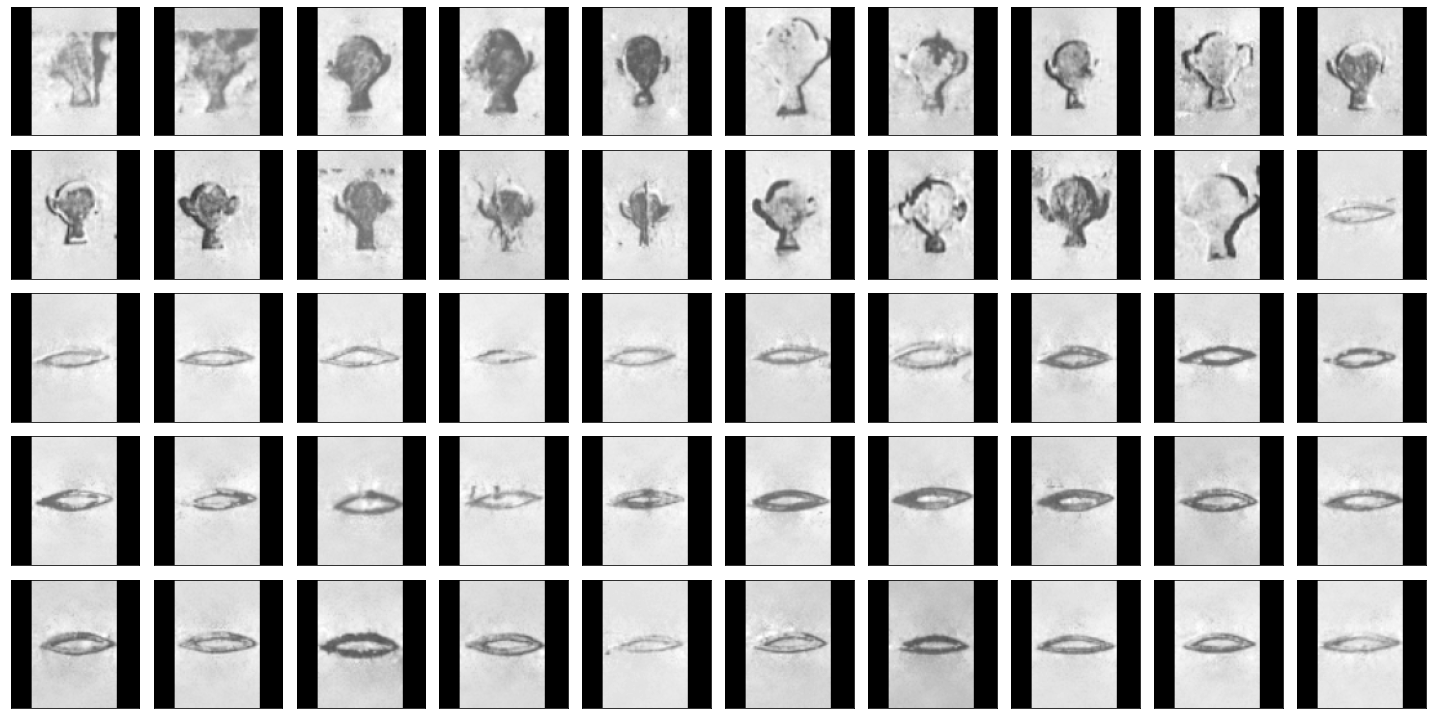

In [14]:
overview(0, 50, x_train)

### ResNet50 model

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

image_shape = (100, 100, 3)
base_model = ResNet50(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelResNet = Sequential()
modelResNet.add(base_model)

modelResNet.add(Dense(256, activation="relu"))
modelResNet.add(Dropout(0.3))
modelResNet.add(Dense(128, activation="relu"))
modelResNet.add(Dropout(0.3))

modelResNet.add(Dense(num_labels, activation = 'softmax'))

In [16]:
train_images_rgb = tf.image.grayscale_to_rgb(x_train)
test_images_rgb = tf.image.grayscale_to_rgb(x_test)

In [17]:
train_images_rgb_resnet = tf.keras.applications.resnet.preprocess_input(train_images_rgb)
test_images_rgb_resnet = tf.keras.applications.resnet.preprocess_input(test_images_rgb)

In [18]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=2, verbose=1)

In [20]:
modelResNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelResNet.fit(
    train_images_rgb_resnet, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_resnet, y_test),
    callbacks=[learning_rate_reduction])

Epoch 1/20
78/78 [==============================] - 35s 446ms/step - loss: 1.6617 - accuracy: 0.6101 - val_loss: 244.7193 - val_accuracy: 0.0598 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 31s 392ms/step - loss: 0.7585 - accuracy: 0.8127 - val_loss: 3.0287 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 30s 389ms/step - loss: 0.6112 - accuracy: 0.8541 - val_loss: 4.3505 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 30s 388ms/step - loss: 0.4159 - accuracy: 0.8974 - val_loss: 0.5944 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 5/20
78/78 [==============================] - 30s 390ms/step - loss: 0.3078 - accuracy: 0.9206 - val_loss: 0.5189 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 6/20
78/78 [==============================] - 30s 389ms/step - loss: 0.2523 - accuracy: 0.9360 - val_loss: 0.5250 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 7/20
78/78 [==============================] - 30s 388ms/

In [21]:
modelResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 24,150,312
Trainable params: 24,097,192
Non-trainable params: 53,120
_______________________________________

In [22]:
scores_resnet = modelResNet.evaluate(test_images_rgb_resnet, y_test)

print("Loss: " + str(scores_resnet[0]))
print("Accuracy: " + str(scores_resnet[1]))

20/20 [==============================] - 2s 97ms/step - loss: 0.1258 - accuracy: 0.9748
Loss: 0.1257571280002594
Accuracy: 0.9748031497001648


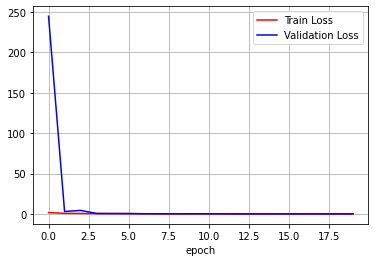

In [23]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

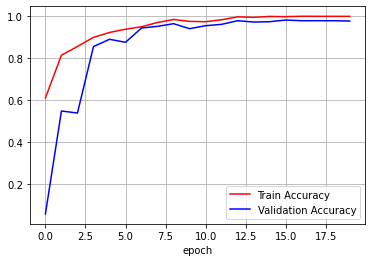

In [24]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

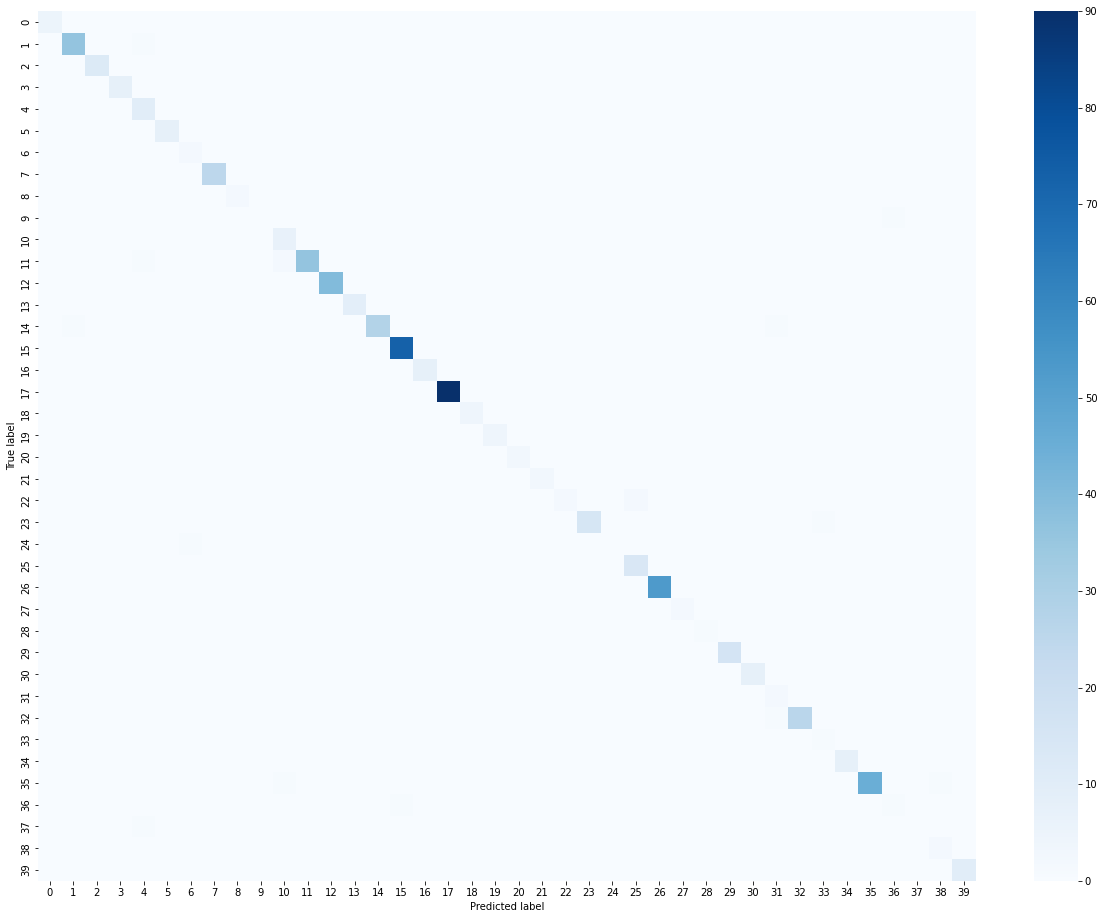

In [25]:
y_pred = [np.argmax(i) for i in modelResNet.predict(test_images_rgb_resnet)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Inception v3 model

In [26]:
from tensorflow.keras.applications import InceptionV3

image_shape = (100, 100, 3)
base_model = InceptionV3(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelInception = Sequential()
modelInception.add(base_model)

modelInception.add(Dense(256, activation="relu"))
modelInception.add(Dropout(0.3))
modelInception.add(Dense(128, activation="relu"))
modelInception.add(Dropout(0.3))

modelInception.add(Dense(num_labels, activation = 'softmax'))

In [27]:
modelInception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                5160      
Total params: 22,365,384
Trainable params: 22,330,952
Non-trainable params: 34,432
_____________________________________

In [28]:
train_images_rgb_inception = tf.keras.applications.inception_v3.preprocess_input(train_images_rgb)
test_images_rgb_inception = tf.keras.applications.inception_v3.preprocess_input(test_images_rgb)

In [29]:
modelInception.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelInception.fit(
    train_images_rgb_inception, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_inception, y_test),
    callbacks=[learning_rate_reduction])

Epoch 1/20
78/78 [==============================] - 26s 327ms/step - loss: 2.0590 - accuracy: 0.5148 - val_loss: 1.0619 - val_accuracy: 0.7370 - lr: 6.4000e-05
Epoch 2/20
78/78 [==============================] - 18s 236ms/step - loss: 0.8080 - accuracy: 0.8221 - val_loss: 0.4696 - val_accuracy: 0.8961 - lr: 6.4000e-05
Epoch 3/20
78/78 [==============================] - 19s 237ms/step - loss: 0.4270 - accuracy: 0.9011 - val_loss: 0.2970 - val_accuracy: 0.9244 - lr: 6.4000e-05
Epoch 4/20
78/78 [==============================] - 18s 236ms/step - loss: 0.3007 - accuracy: 0.9266 - val_loss: 0.1897 - val_accuracy: 0.9512 - lr: 6.4000e-05
Epoch 5/20
78/78 [==============================] - 18s 234ms/step - loss: 0.2471 - accuracy: 0.9424 - val_loss: 0.1357 - val_accuracy: 0.9701 - lr: 6.4000e-05
Epoch 6/20
78/78 [==============================] - 18s 235ms/step - loss: 0.1732 - accuracy: 0.9611 - val_loss: 0.1283 - val_accuracy: 0.9701 - lr: 6.4000e-05
Epoch 7/20
78/78 [======================

In [30]:
scores_inception = modelInception.evaluate(test_images_rgb_inception, y_test)

print("Loss: " + str(scores_inception[0]))
print("Accuracy: " + str(scores_inception[1]))

20/20 [==============================] - 1s 61ms/step - loss: 0.0762 - accuracy: 0.9858
Loss: 0.07623633742332458
Accuracy: 0.9858267903327942


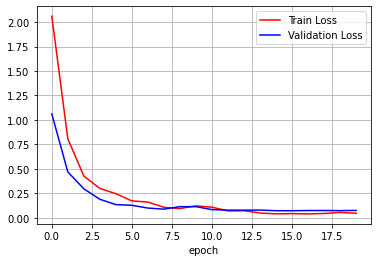

In [31]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

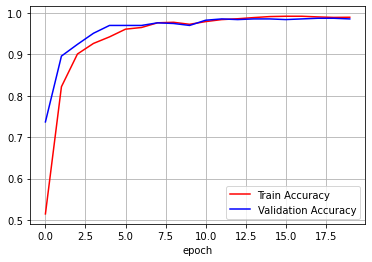

In [32]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

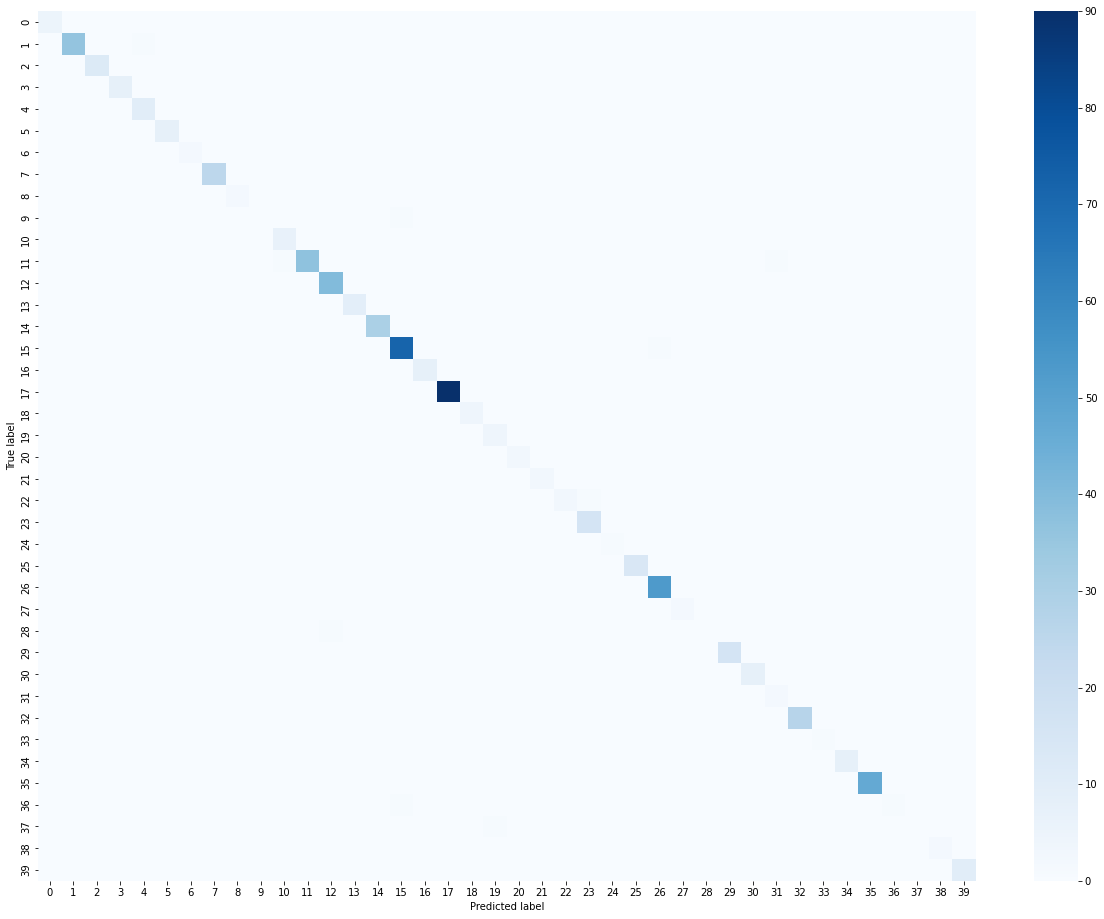

In [33]:
y_pred = [np.argmax(i) for i in modelInception.predict(test_images_rgb_inception)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Xception model

In [34]:
from tensorflow.keras.applications import Xception

image_shape = (100, 100, 3)
base_model = Xception(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelXception = Sequential()
modelXception.add(base_model)

modelXception.add(Dense(256, activation="relu"))
modelXception.add(Dropout(0.3))
modelXception.add(Dense(128, activation="relu"))
modelXception.add(Dropout(0.3))

modelXception.add(Dense(num_labels, activation = 'softmax'))

In [35]:
train_images_rgb_xception = tf.keras.applications.xception.preprocess_input(train_images_rgb)
test_images_rgb_xception = tf.keras.applications.xception.preprocess_input(test_images_rgb)

In [36]:
optimizer = Adam(learning_rate=0.001)

In [37]:
modelXception.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelXception.fit(
    train_images_rgb_xception, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb_xception, y_test),
    callbacks=[learning_rate_reduction])

Epoch 1/20
78/78 [==============================] - 43s 550ms/step - loss: 1.9961 - accuracy: 0.5148 - val_loss: 4.5559 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 39s 499ms/step - loss: 1.0123 - accuracy: 0.7511 - val_loss: 1.0200 - val_accuracy: 0.8236 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 39s 500ms/step - loss: 0.5724 - accuracy: 0.8573 - val_loss: 1.0056 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 39s 503ms/step - loss: 0.4424 - accuracy: 0.8918 - val_loss: 1.4703 - val_accuracy: 0.7701 - lr: 0.0010
Epoch 5/20
78/78 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.8780
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
78/78 [==============================] - 39s 501ms/step - loss: 0.5561 - accuracy: 0.8780 - val_loss: 7.8967 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 6/20
78/78 [==============================] - 39s 5

In [38]:
scores_xception = modelXception.evaluate(test_images_rgb_xception, y_test)

print("Loss: " + str(scores_xception[0]))
print("Accuracy: " + str(scores_xception[1]))

20/20 [==============================] - 2s 97ms/step - loss: 0.0875 - accuracy: 0.9827
Loss: 0.08754636347293854
Accuracy: 0.982677161693573


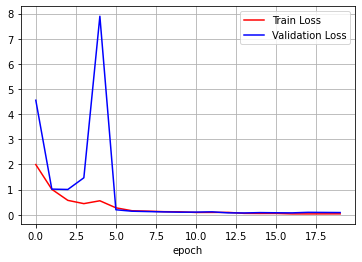

In [39]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

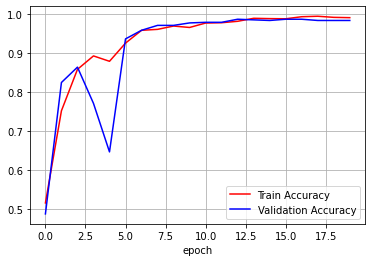

In [40]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

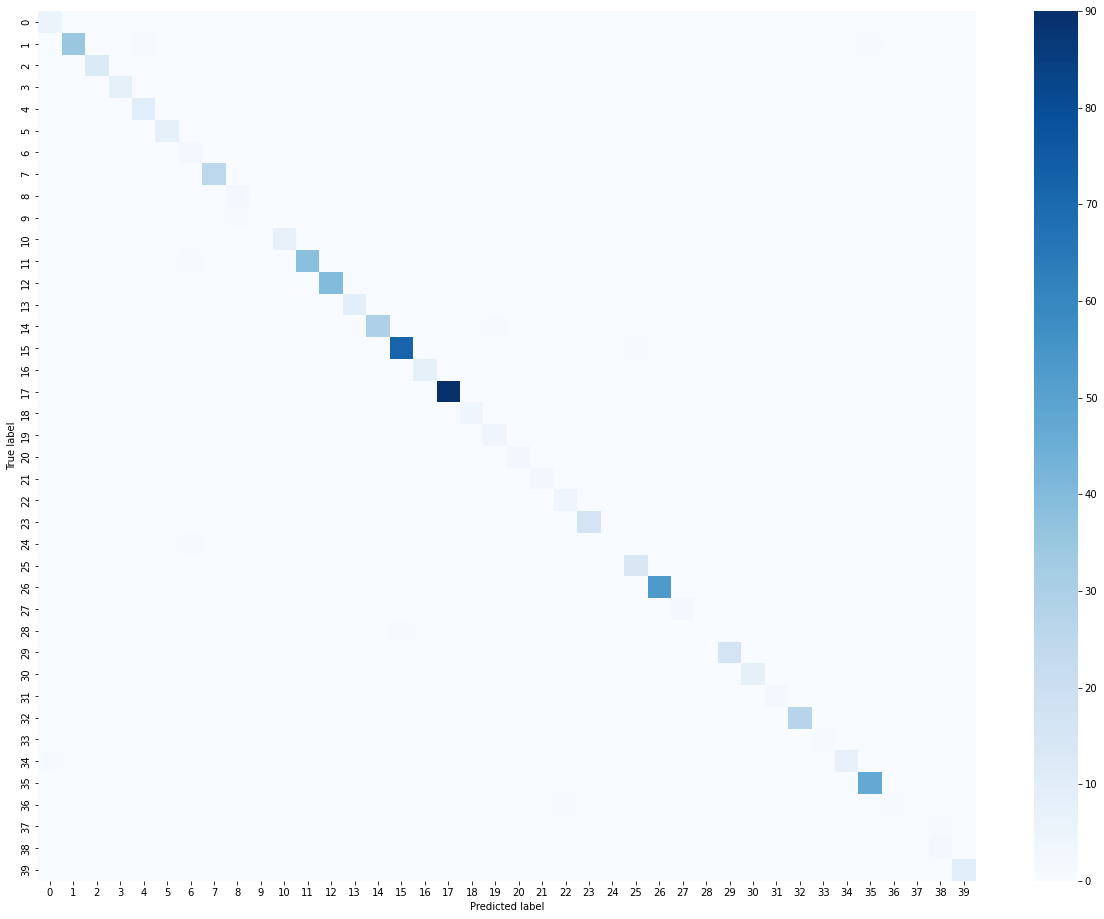

In [41]:
y_pred = [np.argmax(i) for i in modelXception.predict(test_images_rgb_xception)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

### Glyphnet - model architecture proposed in article

In [42]:
model = Sequential()

#first block
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), input_shape=(100, 100, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#second block
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#third block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fourth block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fifth block
model.add(SeparableConv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization_98 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
activation_94 (Activation)   (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 49, 49, 64)        36928     
_________________________________________________________________
batch_normalization_99 (Batc (None, 49, 49, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)       

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

run_hist = model.fit(x_train, y_train,
                     epochs=20,
                     validation_data=(x_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7), learning_rate_reduction])

Epoch 1/20
78/78 [==============================] - 9s 114ms/step - loss: 2.0712 - accuracy: 0.4507 - val_loss: 3.6296 - val_accuracy: 0.1150 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 7s 96ms/step - loss: 0.8833 - accuracy: 0.7722 - val_loss: 3.6597 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 3/20
77/78 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.8608
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
78/78 [==============================] - 7s 96ms/step - loss: 0.5092 - accuracy: 0.8606 - val_loss: 3.8379 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 7s 96ms/step - loss: 0.3177 - accuracy: 0.9092 - val_loss: 4.1718 - val_accuracy: 0.0157 - lr: 4.0000e-04
Epoch 5/20
77/78 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9347
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
78/78 [==============================] - 

In [45]:
scores = model.evaluate(x_test, y_test)

print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

20/20 [==============================] - 1s 29ms/step - loss: 0.0873 - accuracy: 0.9764
Loss: 0.08734076470136642
Accuracy: 0.9763779640197754


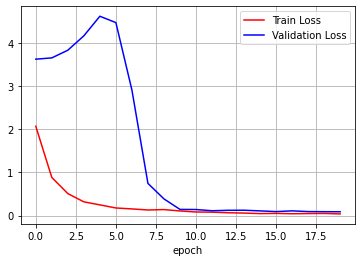

In [46]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

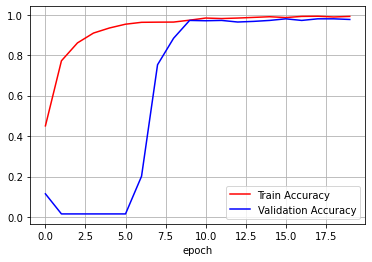

In [47]:
plt.plot(run_hist.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(run_hist.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

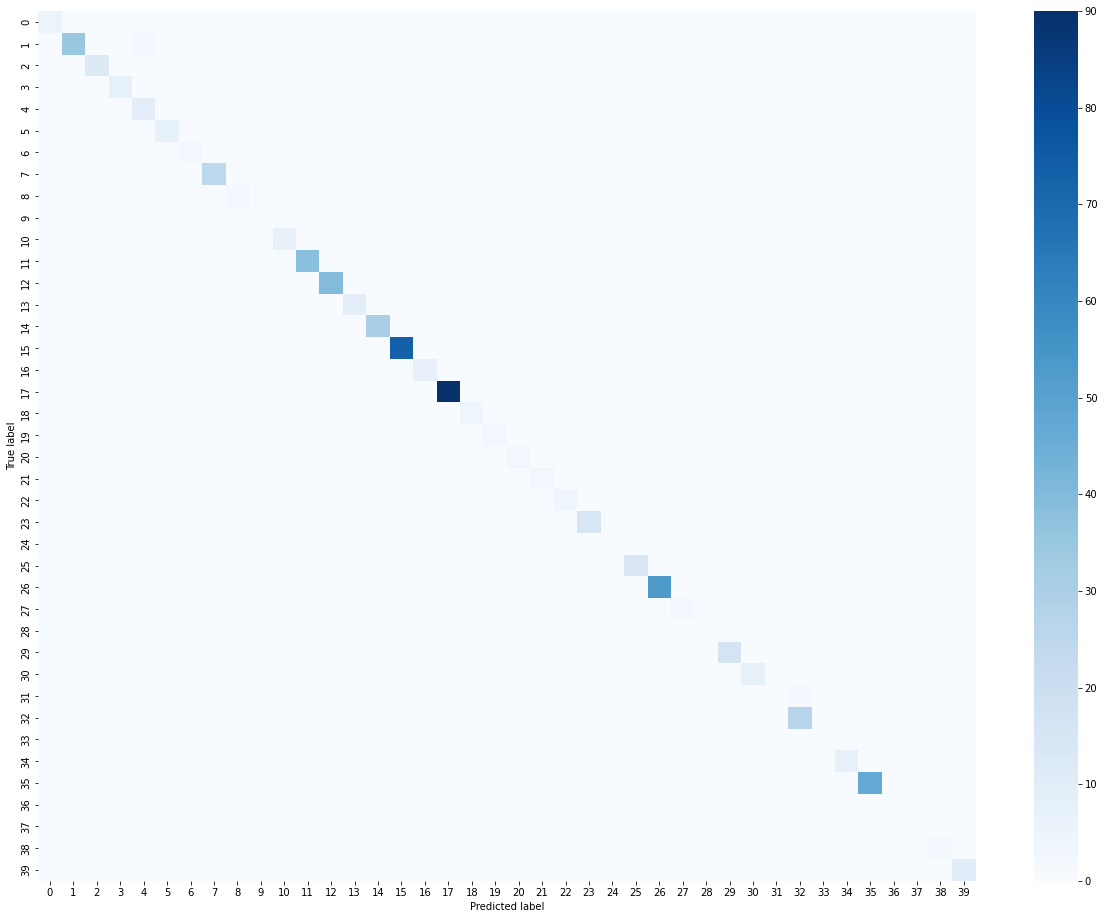

In [48]:
y_pred = [np.argmax(i) for i in model.predict(x_test)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')